# 4. Model Training with Second-Order Optimizers

We can use second-order optimizers to improve the training precision and potentially get better fit results. 

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
from m3util.viz.printing import printer
from m3util.viz.style import set_style
from m3util.ml.rand import set_seeds
from m3util.ml.optimizers.AdaHessian import AdaHessian
from m3util.ml.optimizers.TrustRegion import TRCG
from m3util.util.IO import download_and_unzip, make_folder
from belearn.dataset.dataset import BE_Dataset
from belearn.viz.viz import Viz
from belearn.functions.sho import SHO_nn
from belearn.nn.SHO import SHO_Model
from autophyslearn.postprocessing.complex import ComplexPostProcessor
from autophyslearn.spectroscopic.nn import Multiscale1DFitter, Model


printing = printer(basepath = './Figures/')

set_style("printing")
set_seeds(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads Data


In [2]:
# Specify the filename and the path to save the file
filename = "./data_raw.h5"
save_path = "./Data"


data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

In [3]:
# instantiates the visualization object
BE_viz = Viz(dataset, printing, verbose=True)

## ADAM model

In [4]:
# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

set_seeds(seed=42)

postprocessor = ComplexPostProcessor(dataset)

ADAM_model_ = Multiscale1DFitter(SHO_nn, # function 
                            dataset.frequency_bin, # x data
                            2, # input channels
                            4, # output channels
                            dataset.SHO_scaler, 
                            postprocessor)

# instantiate the model
ADAM_model = Model(ADAM_model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

ADAM_model.fit(
    dataset.X_train,
    5000,
    optimizer="Adam",
    epochs = 5,
)



Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/m3/lib/python3.11/site-packages/torch/autograd/graph.py:769: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/5, recon loss = 0.32031467
--- 9.380922555923462 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/5, recon loss = 0.04128166
--- 9.076172828674316 seconds ---
Epoch 2, Learning Rate: 0.001
Adam
epoch : 3/5, recon loss = 0.03713343
--- 9.054157972335815 seconds ---
Epoch 3, Learning Rate: 0.001
Adam
epoch : 4/5, recon loss = 0.03628556
--- 9.092271089553833 seconds ---
Epoch 4, Learning Rate: 0.001
Adam
epoch : 5/5, recon loss = 0.03583719
--- 9.09972071647644 seconds ---
Epoch 5, Learning Rate: 0.001


## Adahessian

We first try an optimized called [adahessian](https://arxiv.org/abs/2006.00719)

In [5]:
# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

set_seeds(seed=42)

postprocessor = ComplexPostProcessor(dataset)

AdaHessian_ = Multiscale1DFitter(SHO_nn, # function 
                            dataset.frequency_bin, # x data
                            2, # input channels
                            4, # output channels
                            dataset.SHO_scaler, 
                            postprocessor)

# instantiate the model
AdaHessian_model = Model(AdaHessian_, dataset, training=True, 
                         model_basename="SHO_Fitter_original_data_adahessian")


AdaHessian_model.fit(
    dataset.X_train,
    5000,
    optimizer="AdaHessian",
    epochs = 5,
     lr=.15
)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
AdaHessian
epoch : 1/5, recon loss = 0.10786223
--- 13.027852773666382 seconds ---
Epoch 1, Learning Rate: 0.15
AdaHessian
epoch : 2/5, recon loss = 0.04263360
--- 12.918055772781372 seconds ---
Epoch 2, Learning Rate: 0.15
AdaHessian
epoch : 3/5, recon loss = 0.03985478
--- 12.934844493865967 seconds ---
Epoch 3, Learning Rate: 0.15
AdaHessian
epoch : 4/5, recon loss = 0.03862779
--- 12.939868450164795 seconds ---
Epoch 4, Learning Rate: 0.15
AdaHessian
epoch : 5/5, recon loss = 0.03795150
--- 12.89884066581726 seconds ---
Epoch 5, Learning Rate: 0.15


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


./Figures/Figure_4.1_NN_Adahessian_SHO_Fits.png
./Figures/Figure_4.1_NN_Adahessian_SHO_Fits.svg


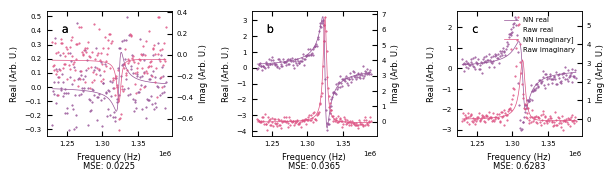

In [11]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=AdaHessian_model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_4_1_NN_Adahessian_SHO_Fits_training",
)

**Figure 4.1** Raw data and reconstruction of the autoencoder trained with Adahessian for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.

./Figures/Figure_4_2_NN_Adahessian_SHO_Fits_testing.png
./Figures/Figure_4_2_NN_Adahessian_SHO_Fits_testing.svg


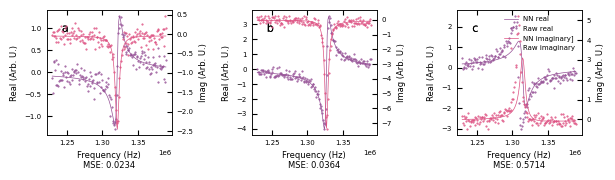

In [12]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=AdaHessian_model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_4_2_NN_Adahessian_SHO_Fits_testing",
)

**Figure 4.2** Raw data and reconstruction of the autoencoder trained with Adahessian for the testing data. Shows the a) best, b) median, and c) worst reconstruction of the testing data.

./Figures/Figure_4_3_NN_Adahessian_SHO_Fits_testing.png
./Figures/Figure_4_3_NN_Adahessian_SHO_Fits_testing.svg


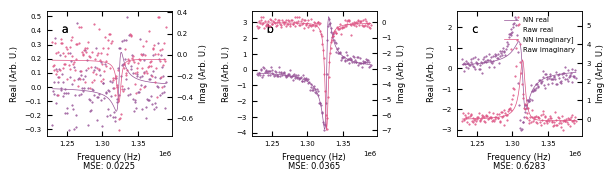

In [13]:
state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=AdaHessian_model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_4_3_NN_Adahessian_SHO_Fits_testing",
)

**Figure 4.3** Raw data and reconstruction of the autoencoder trained with Adahessian for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.

current_SHO_ranges: None
current_dataset_state: {'raw_format': 'complex', 'fitter': 'LSQF', 'scaled': False, 'output_shape': 'pixels', 'measurement_state': 'all', 'LSQF_phase_shift': None, 'NN_phase_shift': 1.5707963267948966, 'noise': 0, 'loop_interpolated': False}
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.png
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.svg


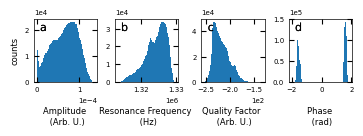

In [17]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = AdaHessian_model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_13_NN_Unscaled_Parameters_Histograms")

**Figure 4.4** Histogram of the fit results computed with the Adahessian optimized neural network for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.

./Figures/Figure_3_5_NN_Switching_Maps.png
./Figures/Figure_3_5_NN_Switching_Maps.svg


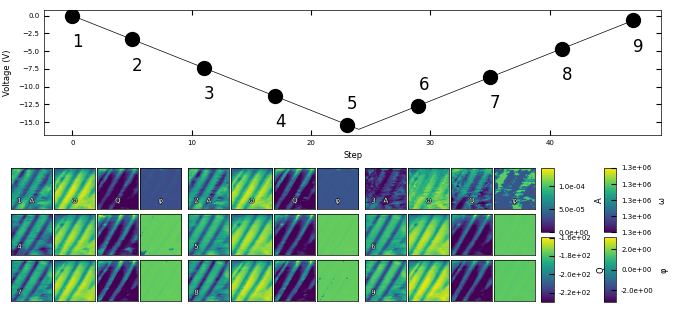

In [19]:
# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = AdaHessian_model.predict(X_data)

BE_viz.SHO_switching_maps(parm, filename="Figure_3_5_NN_Switching_Maps")

**Figure 4.5** Snapshots of the amplitude, resonance frequency, quality factor, and phase of the piezoresponse during ferroelectric switching based on adahessian optimizer fits.

./Figures/Figure_4_5_LSQF_NN_bmw_comparison.png
./Figures/Figure_4_5_LSQF_NN_bmw_comparison.svg


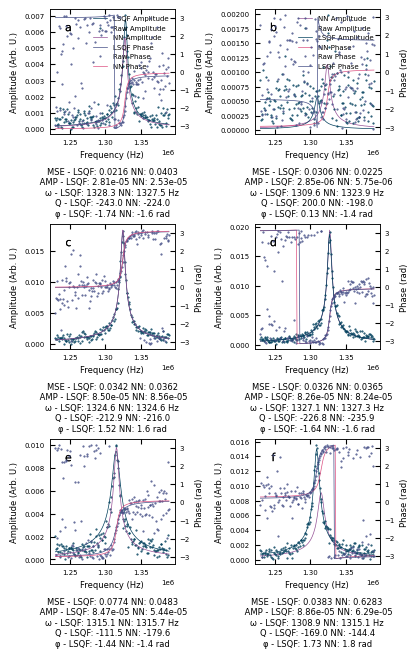

In [22]:
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2
dataset.measurement_state = "all"


true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=AdaHessian_model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[AdaHessian_model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_4_5_LSQF_NN_bmw_comparison",
)

**Figure 4.6** Comparison of the a,b) best, c,d) median, and e,f) worst simple harmonic oscillator fits. a,c,e) are based on the fit results from the simple harmonic oscillator model, wherein b,d,f) are based on the neural network model trained with the Adahessian optimizer. Generally speaking, all fits are good for both models on the as collected data.

./Figures/Figure_4_7_Violin_plot_comparison_SHO_AdaHessian.png
./Figures/Figure_4_7_Violin_plot_comparison_SHO_AdaHessian.svg


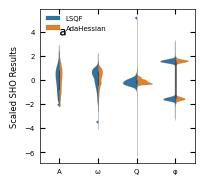

In [28]:
true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

BE_viz.violin_plot_comparison_SHO(true_state, AdaHessian_model, X_data, label='AdaHessian',
                                  filename="Figure_4_7_Violin_plot_comparison_SHO_AdaHessian") 

**Figure 4.7** Comparison of the least-squares and adahessian optimized neural network fitting results.

## Trust Region Optimizer

In [30]:
optimizer = {"name": "TRCG", "optimizer":TRCG, "radius": 5, "device": "cuda","ADAM_epochs": 2}

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

set_seeds(seed=42)

postprocessor = ComplexPostProcessor(dataset)

TRCG_ = Multiscale1DFitter(SHO_nn, # function 
                            dataset.frequency_bin, # x data
                            2, # input channels
                            4, # output channels
                            dataset.SHO_scaler, 
                            postprocessor)

# instantiate the model
TRCG_model = Model(TRCG_, dataset, training=True, model_basename="SHO_Fitter_original_data_TRCG")

TRCG_model.fit(
    dataset.X_train,
    5000,
    optimizer=optimizer,
    epochs = 5,
)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Adam
epoch : 1/5, recon loss = 0.32031467
--- 9.049391508102417 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/5, recon loss = 0.04128166
--- 8.964095115661621 seconds ---
Epoch 2, Learning Rate: 0.001
Adam
epoch : 3/5, recon loss = 0.03713343
--- 9.08246922492981 seconds ---
Epoch 3, Learning Rate: 0.001
Trust Region CG
epoch : 4/5, recon loss = 0.03451130
--- 367.8564462661743 seconds ---
Epoch 4, Learning Rate: 0.001


CG has issues !!!




CG has issues !!!




CG has issues !!!




CG has issues !!!




CG has issues !!!




CG has issues !!!




CG has issues !!!


Trust Region CG
epoch : 5/5, recon loss = 0.03388298
--- 501.88006067276 seconds ---
Epoch 5, Learning Rate: 0.001


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


./Figures/Figure_4_8_NN_TrustRegion_SHO_Fits_training.png
./Figures/Figure_4_8_NN_TrustRegion_SHO_Fits_training.svg


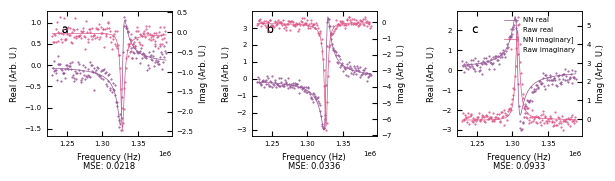

In [31]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=TRCG_model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_4_8_NN_TrustRegion_SHO_Fits_training",
)

**Figure 4.8** Raw data and reconstruction of the autoencoder trained with Trust Region for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.

./Figures/Figure_4_2_NN_Adahessian_SHO_Fits_testing.png
./Figures/Figure_4_2_NN_Adahessian_SHO_Fits_testing.svg


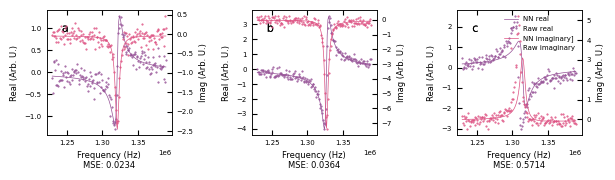

In [12]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=TRCG_model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_4_9_NN_TrustRegion_SHO_Fits_testing",
)

**Figure 4.9** Raw data and reconstruction of the autoencoder trained with trust region for the testing data. Shows the a) best, b) median, and c) worst reconstruction of the testing data.

./Figures/Figure_4_10_NN_validation_full_data.png
./Figures/Figure_4_10_NN_validation_full_data.svg


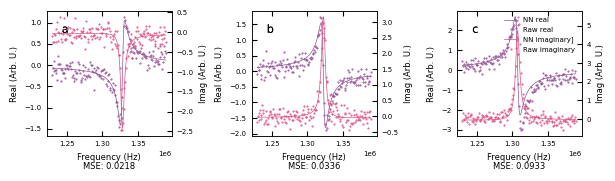

In [33]:
state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=TRCG_model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_4_10_NN_validation_full_data",
)

**Figure 4.10** Raw data and reconstruction of the autoencoder trained with Adahessian for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.

current_SHO_ranges: None
current_dataset_state: {'raw_format': 'complex', 'fitter': 'LSQF', 'scaled': True, 'output_shape': 'index', 'measurement_state': 'all', 'LSQF_phase_shift': 1.5707963267948966, 'NN_phase_shift': 1.5707963267948966, 'noise': 0, 'loop_interpolated': False}
dataset is scaled
./Figures/Figure_4_11_NN_Unscaled_Parameters_Histograms.png
./Figures/Figure_4_11_NN_Unscaled_Parameters_Histograms.svg


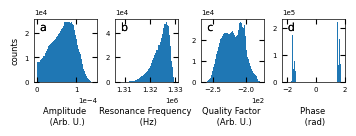

In [34]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = TRCG_model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_4_11_NN_Unscaled_Parameters_Histograms")

**Figure 4.11** Histogram of the fit results computed with the trust region optimized neural network for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.

./Figures/Figure_4_12_NN_Switching_Maps.png
./Figures/Figure_4_12_NN_Switching_Maps.svg


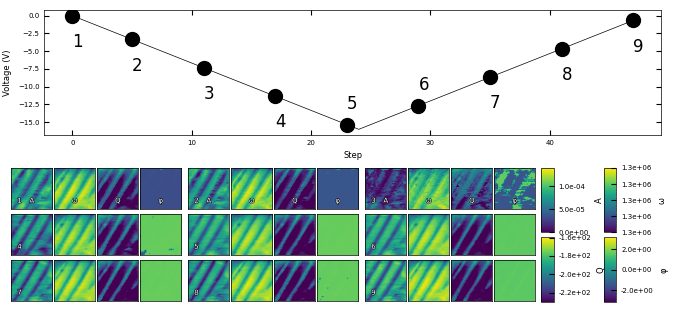

In [35]:
# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = TRCG_model.predict(X_data)

BE_viz.SHO_switching_maps(parm, filename="Figure_4_12_NN_Switching_Maps")

**Figure 4.12** Snapshots of the amplitude, resonance frequency, quality factor, and phase of the piezoresponse during ferroelectric switching based on the trust region optimizer fits.

./Figures/Figure_4_13_LSQF_NN_bmw_comparison_.png
./Figures/Figure_4_13_LSQF_NN_bmw_comparison_.svg


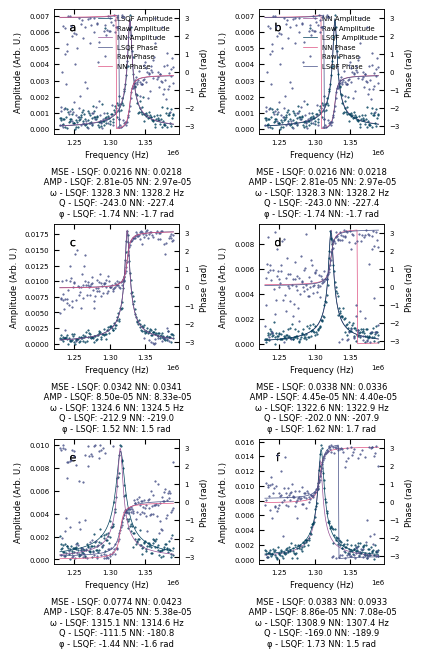

In [37]:
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2
dataset.measurement_state = "all"


true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=TRCG_model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[TRCG_model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_4_13_LSQF_NN_bmw_comparison_Trust_Region",
    # display_results = None
)

**Figure 4.13:** Comparison of the a, b) best, c, d) median, and e, f) worst simple harmonic oscillator fits. a, c, e) are based on the fit results from the simple harmonic oscillator model, whereas b, d, f) are based on the neural network model trained with the Trust Region Optimizer. Generally speaking, all fits are good for both models on the collected data. The Trust Region Optimizer has lower maximum errors than the other neural network models.

./Figures/Figure_4_14_Violin_Trust_Region.png
./Figures/Figure_4_14_Violin_Trust_Region.svg


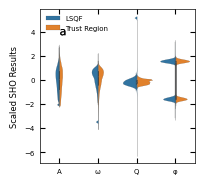

In [41]:
true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}


BE_viz.violin_plot_comparison_SHO(true_state, TRCG_model, X_data, filename="Figure_4_14_Violin_Trust_Region", label="Trust Region") 

**Figure 4.14** Comparison of the least-squares and trust region-optimized neural network fitting results.